<a href="https://colab.research.google.com/github/sir-sauc3/Project2/blob/main/Trial_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import numpy as np
from dataclasses import dataclass
from pprint import pprint
import random
from scipy.signal import correlate2d

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

In [98]:
# class Deer:
  
#   def __init__(self, loc):
#     self.loc = tuple(loc)

#     weight = 20
#     max_weight = 60
#     metabolism = 5

  
#   def step():
#     #make a random cardinal movement
#     #graze if grass is there
#     #increase weight if deer grazed or decrease weight if deer didnt graze
#     return


def random_walk(n):
  x,y = 0,0

  for i in range(n):
    dx, dy = random.choice([(1,0), (-1,0), (0,1), (0,-1)])
    x+=dx
    y+=dy

  return((x, y))


for i in range(10):
  test = random_walk(15)
  print(f'abs coordinate positions are: {test}')

abs coordinate positions are: (2, -1)
abs coordinate positions are: (0, 1)
abs coordinate positions are: (-1, 4)
abs coordinate positions are: (-3, 0)
abs coordinate positions are: (1, 0)
abs coordinate positions are: (-3, 0)
abs coordinate positions are: (-1, 0)
abs coordinate positions are: (3, -2)
abs coordinate positions are: (3, 2)
abs coordinate positions are: (-2, 3)


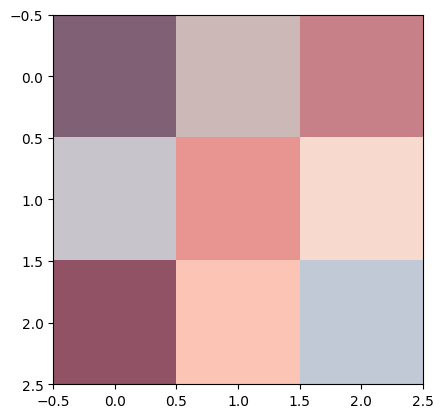

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Create two NumPy arrays of the same size
arr1 = np.random.rand(3, 3)
arr2 = np.random.rand(3, 3)

# Display the arrays over each other using imshow
fig, ax = plt.subplots()
ax.imshow(arr1, cmap='Blues', alpha=0.5)
ax.imshow(arr2, cmap='Reds', alpha=0.5)
plt.show()

[[0.72353175 0.36213463 0.22605326]
 [0.87198622 0.12714589 0.51188548]
 [0.89915842 0.9219417  0.43906965]]


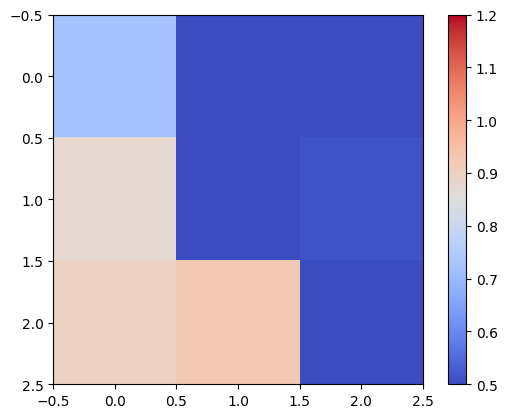

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 3x3 NumPy array with random values
arr = np.random.rand(3, 3)

print(arr)
# Display the array using a custom colormap
fig, ax = plt.subplots()
im = ax.imshow(arr, cmap='coolwarm', vmin=0.5, vmax=1.2)

# Add a colorbar to show the mapping of values to colors
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

[[ 0.27342729 -0.02932217  1.57515195]
 [ 0.53989721  1.14028014  1.28646134]
 [-0.86448318 -0.34486066 -0.33121978]]


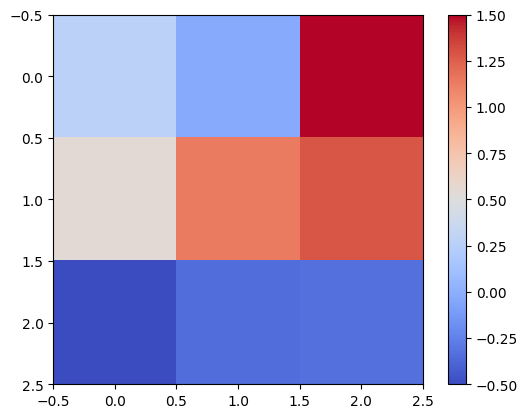

In [101]:
import numpy as np

arr = np.random.uniform(low=-1, high=2, size=(3, 3))

print(arr)
fig, ax = plt.subplots()
im = ax.imshow(arr, cmap='coolwarm', vmin=-0.5, vmax=1.5)

# Add a colorbar to show the mapping of values to colors
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [133]:
class Grazing_sim:

  kernel = np.array([[0, 1, 0],
                     [1, 0, 1],
                     [0, 1, 0]])

  def __init__(self, size, deer_amt, q):
    self.size = size
    self.deer_amt = deer_amt
    self.q = q
    self.one = np.random.choice([1, 0], (self.size,self.size), p=(q, 1-q))
    two = np.random.choice(self.size**2, size=deer_amt, replace=False)
    x, y = np.unravel_index(two, (self.size, self.size))
    two = np.zeros((self.size,self.size))
    two[x,y] = 3

    # print(self.one)
    # correlated_matrix = correlate2d(self.one, self.kernel, mode='same', boundary='wrap')
    # print('\n')
    # print(correlated_matrix)

    self.three = np.where(two==3, two, self.one).astype(int)
    # print(self.three)


  def draw(self):
    fig, ax = plt.subplots()
    cmap = [(225/225, 248/255, 220/255),(0,1,0),(0,0,0),(165/255, 42/255, 42/255)]
    field_color_map = matplotlib.colors.ListedColormap(cmap)
    ax.imshow(self.three, cmap=field_color_map, vmin=0, vmax=3)

    # title = f'Time:{step}'
    ax.axis('off')
    plt.show()

# print(one)
# print(two)

# deer_loc = two==3
# print(deer_loc)


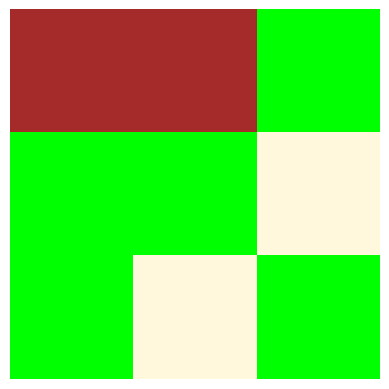

In [148]:
q = 0.5
size = 3
deer_amt = 2

test = Grazing_sim(size, deer_amt, q)

loc = test.three[test.three==3]
# print(loc)

# coord = [position.location for position in loc]
test.draw()

In [127]:
import numpy as np
from scipy.signal import correlate2d

# Define your kernel k here
k = np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 1, 0]])

q = 0.3
size = 5
num = 3
M = np.random.choice([0,1], (size,size), p=(q, 1-q))
two = np.random.choice(size**2, size=3, replace=False)
print(two)
(x, y) = np.unravel_index(two, (size, size))
# occ_loc = [(x,y) for x,y in np.unravel_index(two, (size, size))]
two = np.zeros((size,size))
print(x,y)
for xy in zip(x,y):
  print(xy)
two[x,y] = 3
print(two)
three = np.where(two==3, two, M).astype(int)

# Calculate the correlated matrix C
C = correlate2d(M, k, mode='same', boundary='wrap')
# correlate2d(self.one, self.kernel, mode='same', boundary='wrap')

# Define a function to get the highest value neighbor given a cell index
def get_highest_neighbor(cell_idx):
    i, j = cell_idx
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)] # cardinal neighbors
    neighbor_values = [C[n] for n in neighbors if (0 <= n[0] < C.shape[0]) and (0 <= n[1] < C.shape[1])] # get neighbor values
    if len(neighbor_values) > 0:
        highest_neighbor = neighbors[np.argmax(neighbor_values)]
    else:
        highest_neighbor = cell_idx # stay put if no neighbors
    return highest_neighbor

# Move agents based on highest value neighbor
# for agent in A:
#     current_location = agent.location
#     highest_neighbor = get_highest_neighbor(current_location)
#     agent.move_to(highest_neighbor)



[12  5 13]
[2 1 2] [2 0 3]
(2, 2)
(1, 0)
(2, 3)
[[0. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0.]
 [0. 0. 3. 3. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [149]:
print('field\n')
print(M)
print('\n\nfield with deer\n')
print(three)
print('\n\ncorrelated field\n')
print(C)

unoccupied = three<3
print('\n\ncells with no deer\n')
print(unoccupied)
print('\n')


i=2
j=2


print(f'the value of C[{i},{j}] is {C[i,j]}\n')


neighbors = [(i-1, j), (i, j+1), (i+1, j), (i, j-1)] #up, right, down, left
neighbor_values = [C[n] for n in neighbors if (0 <= n[0] < C.shape[0]) and (0 <= n[1] < C.shape[1])]
neighbor_values = [
                   C[n] if (n[0] < C.shape[0] and n[1] < C.shape[1])
                   else C[0, n[1]] if (n[0] >= C.shape[0])
                   else C[n[0], 0] if (n[1] >= C.shape[1])
                   else 0
                   for n in neighbors]



print(f'The neighbor values of i={i} and j={j} are {neighbor_values}\nAnd the index of the highest neighbor is {np.argmax(neighbor_values)}')

# for ji in neighbors:
#   print(f'ji[0] = {ji[0]}\tji[1] = {ji[1]}\tC.shape[0] = {C.shape[0]}\tC.shape[1] = {C.shape[1]}')
#   print(ji[0] < C.shape[0] and ji[1] < C.shape[1])
# print(C.shape)

# (y,x) = np.where(M == 1)

# print(y,x)

# print(get_highest_neighbor((3,1)))

field

[[1 1 1 1 1]
 [0 0 0 1 1]
 [0 0 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 1]]


field with deer

[[1 1 1 1 1]
 [3 0 0 1 1]
 [0 0 3 3 0]
 [1 1 1 1 1]
 [0 0 1 0 1]]


correlated field

[[2 2 3 3 4]
 [2 1 3 3 2]
 [1 2 2 3 3]
 [2 2 4 3 3]
 [3 3 2 4 2]]


cells with no deer

[[ True  True  True  True  True]
 [False  True  True  True  True]
 [ True  True False False  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


the value of C[2,2] is 2

The neighbor values of i=2 and j=2 are [3, 3, 4, 2]
And the index of the highest neighbor is 2


In [106]:
'''
Probably want to use a kernel to tell the value of the neighboring cells
When a deer 'sees' that theres's a cell with a value of 1, it moves there

choosinng a cell to move to
1. make a chek_if_occupied_neighborhood function that checks if there are other deer in its cardinal neighbors
'''

"\nProbably want to use a kernel to tell the value of the neighboring cells\nWhen a deer 'sees' that theres's a cell with a value of 1, it moves there\n\nchoosinng a cell to move to\n1. make a chek_if_occupied_neighborhood function that checks if there are other deer in its cardinal neighbors\n"

In [119]:
import numpy as np

def move_to(current_pos, C, occupied_cells):
    # Get neighboring cells of current position
    neighbors = [(current_pos[0]+i, current_pos[1]+j) 
                  if (current_pos[0]+i < C.shape[0]) and (current_pos[1]+j < C.shape[1])
                  else C[0, current_pos[1]+j] if (current_pos[0]+i >= C.shape[0])
                  else C[current_pos[1]+i, 0] if (current_pos[1]+j >= C.shape[1])
                  else 0
                  for i in [-1, 1] for j in [-1, 1] 
                 ]


    
    # Remove occupied cells from list of available neighbors
    available_neighbors = [n for n in neighbors if n not in occupied_cells]
    
    # If all neighbors are occupied, stay in current position
    if len(available_neighbors) == 0:
        return current_pos
    
    # Calculate values of neighboring cells in correlated matrix
    neighbor_values = [C[n] for n in available_neighbors if (0 <= n[0] < C.shape[0]) and (0 <= n[1] < C.shape[1])]
    
    # Get index of neighboring cell with highest value
    best_neighbor_index = np.argmax(neighbor_values)
    
    # Choose the best neighboring cell to move to
    best_neighbor = available_neighbors[best_neighbor_index]
    
    return best_neighbor


In [107]:
import numpy as np

# Create the first array with 0s and 1s
arr1 = np.array([[1, 0, 1],
                 [0, 1, 0],
                 [1, 1, 0]])

# Create the second array with 0s and 3s
arr2 = np.array([[0, 0, 0],
                 [3, 3, 0],
                 [0, 0, 3]])

# Create the third array by combining the first and second arrays
arr3 = np.where(arr2 == 3, arr2, arr1)

# Print the arrays to check the result
print("Array 1:\n", arr1)
print("Array 2:\n", arr2)
print("Array 3:\n", arr3)

Array 1:
 [[1 0 1]
 [0 1 0]
 [1 1 0]]
Array 2:
 [[0 0 0]
 [3 3 0]
 [0 0 3]]
Array 3:
 [[1 0 1]
 [3 3 0]
 [1 1 3]]
